In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/starcraft-2-player-prediction-challenge-2020/TEST.CSV
/kaggle/input/starcraft-2-player-prediction-challenge-2020/TRAIN.CSV
/kaggle/input/starcraft-2-player-prediction-challenge-2020/TEST_LONG.CSV
/kaggle/input/starcraft-2-player-prediction-challenge-2020/SAMPLE_SUBMISSION.CSV
/kaggle/input/starcraft-2-player-prediction-challenge-2020/TRAIN_LONG.CSV


# Data Collecting

In [2]:
pip install dtw-python

     |████████████████████████████████| 570 kB 193 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Libraries
import pandas as pd
import numpy as np
#from numpy import genfromtxt
pd.options.mode.chained_assignment = None
from sklearn import preprocessing
from dtw import *

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [4]:
# Reading data - fetching TRAIN.csv data from the long version

#lenth_of_line = 6695 # can be automated
df_train_tmp = pd.read_csv("/kaggle/input/starcraft-2-player-prediction-challenge-2020/TRAIN_LONG.CSV", error_bad_lines=False, warn_bad_lines=False)
lenth_of_line = df_train_tmp.shape[1]
print ("lenth_of_line", lenth_of_line)


colnames = list()
colnames.append("id")
colnames.append("game_type")
for i in range (lenth_of_line-2):
    colnames.append("move"+str(i))
len (colnames)

df_train = pd.read_csv("/kaggle/input/starcraft-2-player-prediction-challenge-2020/TRAIN_LONG.CSV",names=colnames, header=None, error_bad_lines=False, warn_bad_lines=False)
n_training_games = df_train.shape[0]
print ("n_training_games", n_training_games)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (6427,6428,6429,6430,6431,6432,6433,6434,6435,6436,6437,6438,6439,6440,6441,6442,6443,6444,6445,6446,6447,6448,6449,6450,6451,6452,6453,6454,6455,6456,6457,6458,6459,6460,6461,6462,6463,6464,6465,6466,6467,6468,6469,6470,6471,6472,6473,6474,6475,6476,6477,6478,6479,6480,6481,6482,6483,6484,6485,6486,6487,6488,6489,6490,6491,6492,6493,6494,6495,6496,6497,6498,6499,6500,6501,6502,6503,6504,6505,6506,6507,6508,6509,6510,6511,6512,6513,6514,6515,6516,6517,6518,6519,6520,6521,6522,6523,6524,6525,6526,6527,6528,6529,6530,6531,6532,6533,6534,6535,6536,6537,6538,6539,6540,6541,6542,6543,6544,6545,6546,6547,6548,6549,6550,6551,6552,6553,6554,6555,6556,6557,6558,6559,6560,6561,6562,6563,6564,6565,6566,6567,6568,6569,6570,6571,6572,6573,6574,6575,6576,6577,6578,6579,6580,6581,6582,6583,6584,6585,6586,6587,6588,6589,6590,6591,6592,6593,6594,6595,6596,6597,6598,6599,6600,6601,6602,6603,6604,6605,6606

lenth_of_line 6695
n_training_games 3052


In [5]:
df_train.head()

,id,game_type,move0,move1,move2,move3,move4,move5,move6,move7,...,move6683,move6684,move6685,move6686,move6687,move6688,move6689,move6690,move6691,move6692
0,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,6:CameraEvent:26.0:155.7578125,16:SelectionEvent:Nexus,18:BasicCommandEvent:TrainProbe,21:SelectionEvent:Probe;Probe,25:TargetPointCommandEvent:27.7021484375:162.0...,32:SelectionEvent:Probe,33:TargetUnitCommandEvent:CAbil:MineralField,43:SelectionEvent:Probe,...,26431:TargetPointCommandEvent:46.4304199219:14...,26434:TargetPointCommandEvent:46.6022949219:14...,26439:ControlGroupEvent:3:2,26439:CameraEvent:59.4609375:144.640625,26441:CameraEvent:59.4609375:140.4140625,26441:ControlGroupEvent:4:2,26442:CameraEvent:59.4609375:137.7265625,26446:ControlGroupEvent:5:2,26449:ControlGroupEvent:6:2,"26476:ChatEvent:""gg"""
1,http://eu.battle.net/sc2/en/profile/3074362/1/...,Protoss,6:CameraEvent:158.0:24.7578125,21:SelectionEvent:Probe;Probe,22:TargetUnitCommandEvent:CAbil:MineralField,28:SelectionEvent:Nexus,29:BasicCommandEvent:TrainProbe,32:SelectionEvent:Probe,33:TargetUnitCommandEvent:CAbil:MineralField,40:SelectionEvent:Nexus,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,4:CameraEvent:140.0:24.7578125,14:SelectionEvent:Nexus,16:BasicCommandEvent:TrainProbe,18:SelectionEvent:Probe;Probe,21:TargetUnitCommandEvent:CAbil:MineralField,28:SelectionEvent:Probe,30:TargetUnitCommandEvent:CAbil:MineralField,34:TargetUnitCommandEvent:CAbil:MineralField,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,http://eu.battle.net/sc2/en/profile/3074362/1/...,Protoss,5:CameraEvent:28.0:135.7578125,14:SelectionEvent:Nexus,16:BasicCommandEvent:TrainProbe,20:SelectionEvent:Probe;Probe,22:TargetUnitCommandEvent:CAbil:MineralField,28:SelectionEvent:Nexus,32:SelectionEvent:Probe,34:TargetUnitCommandEvent:CAbil:MineralField,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,5:CameraEvent:20.0:37.2578125,16:SelectionEvent:Nexus,18:BasicCommandEvent:TrainProbe,21:SelectionEvent:Probe;Probe,24:TargetUnitCommandEvent:CAbil:MineralField,29:SelectionEvent:Probe,33:TargetUnitCommandEvent:CAbil:MineralField,40:SelectionEvent:Nexus,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Cleaning Training Data
#df_train.dropna(how='all')
df_train.dropna(subset=['move0'], inplace=True)
df_train.reset_index(drop=True, inplace = True)
df_train.tail(3)

,id,game_type,move0,move1,move2,move3,move4,move5,move6,move7,...,move6683,move6684,move6685,move6686,move6687,move6688,move6689,move6690,move6691,move6692
3044,http://xx.battle.net/sc2/en/profile/405/1/MMA/,Terran,4:CameraEvent:158.0:155.7578125,14:SelectionEvent:OrbitalCommandFlying,14:BasicCommandEvent:TrainSCV,18:SelectionEvent:SCV,20:TargetPointCommandEvent:156.681396484:160.1...,24:TargetUnitCommandEvent:CAbil:MineralField,30:SelectionEvent:OrbitalCommandFlying,34:TargetUnitCommandEvent:CAbil:MineralField,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3045,http://xx.battle.net/sc2/en/profile/410/1/STBo...,Terran,5:CameraEvent:26.99609375:134.7578125,14:SelectionEvent:OrbitalCommand,14:BasicCommandEvent:TrainSCV,18:SelectionEvent:SCV,21:TargetUnitCommandEvent:CAbil:MineralField,25:ControlGroupEvent:1:0,28:SelectionEvent:OrbitalCommand,28:ControlGroupEvent:2:0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3046,http://xx.battle.net/sc2/en/profile/405/1/MMA/,Terran,4:CameraEvent:117.0:21.7578125,17:SelectionEvent:OrbitalCommand,17:BasicCommandEvent:TrainSCV,21:SelectionEvent:SCV,21:TargetPointCommandEvent:115.664550781:20.94...,25:TargetUnitCommandEvent:CAbil:MineralField,30:SelectionEvent:OrbitalCommand,36:ControlGroupEvent:1:0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Reading data - fetching TEST.csv data

#lenth_of_line = 3446 # can be automated
df_train_tmp = pd.read_csv("/kaggle/input/starcraft-2-player-prediction-challenge-2020/TEST_LONG.CSV", error_bad_lines=False, warn_bad_lines=False)
lenth_of_line = df_train_tmp.shape[1]
print ("lenth_of_line", lenth_of_line)
colnames = list()
colnames.append("game_type")
for i in range (lenth_of_line-1):
    colnames.append("move"+str(i))
len (colnames)

df_test = pd.read_csv("/kaggle/input/starcraft-2-player-prediction-challenge-2020/TEST_LONG.CSV",names=colnames, header=None, error_bad_lines=False, warn_bad_lines=False)
n_testing_games = df_test.shape[0]
print ("n_testing_games", n_testing_games)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5810,5811,5812,5813,5814,5815,5816,5817,5818,5819,5820,5821,5822,5823,5824,5825,5826,5827,5828) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


lenth_of_line 5829
n_testing_games 340


In [8]:
df_test.tail()

,game_type,move0,move1,move2,move3,move4,move5,move6,move7,move8,...,move5818,move5819,move5820,move5821,move5822,move5823,move5824,move5825,move5826,move5827
335,Terran,4:CameraEvent:45.0:47.7578125,13:SelectionEvent:OrbitalCommand,13:BasicCommandEvent:TrainSCV,17:SelectionEvent:SCV,21:TargetUnitCommandEvent:CAbil:MineralField,28:SelectionEvent:SCV,32:TargetPointCommandEvent:41.68359375:52.0009...,34:TargetUnitCommandEvent:CAbil:MineralField,43:SelectionEvent:OrbitalCommand,...,18775:CameraEvent:133.83984375:127.23828125,18777:TargetPointCommandEvent:128.928222656:12...,18788:ControlGroupEvent:4:2,18790:BasicCommandEvent:TrainMarauder,18793:CameraEvent:174.8984375:133.00390625,18793:BasicCommandEvent:TrainMarauder,18794:CameraEvent:162.07421875:126.1796875,18797:BasicCommandEvent:TrainMarine,18800:BasicCommandEvent:TrainMarine,18801:CameraEvent:148.640625:125.55859375
336,Protoss,4:CameraEvent:117.0:21.7578125,13:SelectionEvent:Nexus,13:BasicCommandEvent:TrainProbe,17:SelectionEvent:Probe;Probe,21:TargetUnitCommandEvent:CAbil:MineralField,29:SelectionEvent:,33:TargetUnitCommandEvent:CAbil:MineralField,40:SelectionEvent:Nexus,40:ControlGroupEvent:1:0,...,16086:SelectionEvent:,16088:CameraEvent:102.01171875:21.1015625,16088:TargetPointCommandEvent:115.910888672:19...,16088:CameraEvent:103.98046875:21.1015625,16090:ControlGroupEvent:5:2,16096:TargetPointCommandEvent:107.913330078:20...,16098:TargetPointCommandEvent:110.754394531:21...,16102:TargetPointCommandEvent:111.495849609:21...,16108:TargetPointCommandEvent:114.284912109:21...,16113:ControlGroupEvent:2:2
337,Terran,4:CameraEvent:98.0:155.7578125,14:SelectionEvent:OrbitalCommand,16:BasicCommandEvent:TrainSCV,18:SelectionEvent:SCV,21:TargetUnitCommandEvent:CAbil:MineralField,28:ControlGroupEvent:1:0,30:SelectionEvent:OrbitalCommand,32:ControlGroupEvent:2:0,36:SelectionEvent:SCV;SCV;SCV;SCV;SCV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
338,Terran,4:CameraEvent:22.0:15.7578125,14:SelectionEvent:OrbitalCommand,14:BasicCommandEvent:TrainSCV,18:SelectionEvent:SCV,21:TargetPointCommandEvent:19.6926269531:19.27...,26:TargetPointCommandEvent:18.9331054688:19.65...,28:TargetPointCommandEvent:18.6674804688:19.65...,32:TargetUnitCommandEvent:CAbil:MineralField,37:SelectionEvent:OrbitalCommand,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
339,Terran,5:CameraEvent:146.0:19.7578125,16:SelectionEvent:OrbitalCommand,16:BasicCommandEvent:TrainSCV,20:SelectionEvent:SCV,22:TargetUnitCommandEvent:CAbil:MineralField,36:ControlGroupEvent:1:0,37:SelectionEvent:OrbitalCommand,40:ControlGroupEvent:2:0,45:SelectionEvent:SCV;SCV;SCV;SCV;SCV;SCV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Extracting Time Series

In [10]:
from tqdm import tqdm

In [11]:
#action = df.iloc[game_index]["move"+str(move_number)]
    
n_games,len_line= df_train.shape
ts_size = 960 # Number of frames in the time series
time_series = []
for index,data in tqdm(df_train.head(100).iterrows()):
    #time_serie = np.zeros(ts_size)
    time_serie = [-1]*ts_size
    for move_number in range(len_line-2):
        move = data["move"+str(move_number)]
        if move == move:
            #print ("here1")
            #print (data["move"+str(move_number)])
            move_split = move.split(":")
            if len(move_split)>=2:
                #print("here2")
                #print(data_split[0])
                #print (data_split)
                frame = int(move_split[0])
                event = move_split[1]
                if frame < ts_size:
                    #print ("here3") 
                    if event == "ControlGroupEvent":
                        event_hotkey = int(move_split[2])
                        event_update_type = move_split[3]
                        time_serie[frame] = event_hotkey
                        #print(event_hotkey)
                        #print (frame)
                        #print(move)
                else:
                    break
    #print("-------------------------------")
    time_series.append(time_serie)      
    

100it [00:00, 186.39it/s]


In [12]:
len(time_series)

100

# Data Visualisation

In [13]:
from matplotlib import pyplot as plt

In [ ]:
# Plot the first n games
first_games = 20
plt.figure(1,figsize=(14,5))
player_id = str(df_train['id'][1])
x = range(1,len(time_series[0])+1)
for index, data in df_train.head(first_games).iterrows():
    plt.scatter(x,time_series[index])

plt.title("Games for first "+ str(first_games)+" players")
plt.xlabel('frames')
plt.ylabel('moves')


Text(0, 0.5, 'moves')

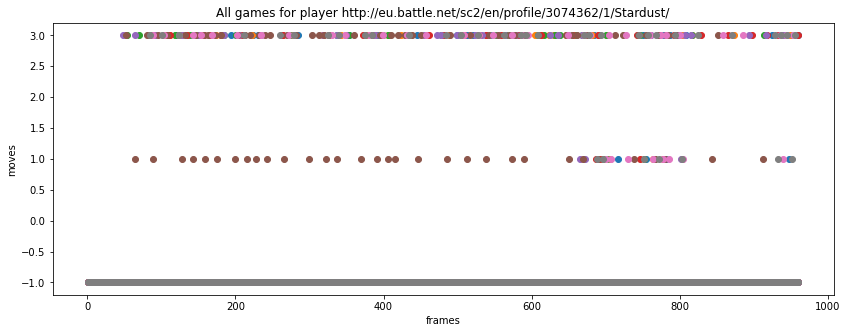

In [14]:
# Plot all of the games for a given player
plt.figure(1,figsize=(14,5))
player_id = str(df_train['id'][1])
x = range(1,len(time_series[0])+1)
for index, data in df_train.head(len(time_series)).iterrows():
    if data['id'] == player_id:
        #print (len(x))
        #print (len(time_series[index]))
        plt.scatter(x,time_series[index])

plt.title("All games for player "+ player_id)
plt.xlabel('frames')
plt.ylabel('moves')


In [15]:
#custom metric
def DTW(a, b):   
    return dtw(a, b, dist_method='euclidean',keep_internals=True).distance

# Training KNN

In [16]:
import numpy as np
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [17]:
X = time_series
y = list(df_train['id'])[:len(time_series)]
print (len(X),len(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#Train
knn_model = KNeighborsClassifier(metric=DTW, n_neighbors = 1)

## Train with GridSearch
#parameters = {'n_neighbors':[2, 4, 8]}
#knn_model = GridSearchCV(KNeighborsClassifier(metric=DTW), parameters, cv=3, verbose=1)

# fit
print ("start fit")
knn_model.fit(X_train, y_train)

#evaluate
print ("start eval")
y_pred = knn_model.predict(X_test)
print(classification_report(y_test, y_pred))
#print (knn_model.best_estimator_)
#print (knn_model.best_score_)

100 100
start fit
start eval
                                                         precision    recall  f1-score   support

  http://eu.battle.net/sc2/en/profile/1021189/1/Dayshi/       1.00      1.00      1.00         1
   http://eu.battle.net/sc2/en/profile/1058669/1/Happy/       1.00      0.50      0.67         2
  http://eu.battle.net/sc2/en/profile/2222468/1/dTefel/       1.00      1.00      1.00         1
 http://eu.battle.net/sc2/en/profile/2452136/1/MinChul/       1.00      1.00      1.00         3
   http://eu.battle.net/sc2/en/profile/250458/1/VortiX/       0.50      0.50      0.50         2
 http://eu.battle.net/sc2/en/profile/251061/1/LiveZerg/       0.60      1.00      0.75         3
 http://eu.battle.net/sc2/en/profile/2896854/1/MǂForGG/       0.75      1.00      0.86         3
     http://eu.battle.net/sc2/en/profile/2898004/1/MMA/       1.00      0.50      0.67         4
http://eu.battle.net/sc2/en/profile/3074362/1/Stardust/       0.50      1.00      0.67         2


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AttributeError: 'KNeighborsClassifier' object has no attribute 'best_estimator_'

## Evaluating the unlabeled testing set - Creating submission file

In [ ]:
#final_model = DecisionTreeClassifier()
final_model = RandomForestClassifier(n_estimators= 2000, min_samples_split= 2, min_samples_leaf= 1, max_features= "auto", max_depth= 200, bootstrap= False)
#final_model = XGBClassifier()
final_model.fit(X,y)

# Predict the response for test dataset
#y_pred = clf.predict(X_test)
submission = final_model.predict(df_test_features[feature_cols])

In [ ]:
file_name = "submission7"
df_submission = pd.DataFrame()
df_submission['RowId'] = range(1,len(submission)+1)
df_submission['prediction'] = submission
df_submission.to_csv('/kaggle/working/'+file_name+'.csv', index = False)
df_submission.head()

# ---------------------MORE VISUALISATION----------------------- 

In [ ]:
#count number of players/labels in training dataset

list_unique_id = np.array(df_train["id"].unique())
print ("there are %d player labels in the training dataset"%len(list_unique_id))

In [ ]:
# [old Code]

# Adding first feature = type of game played
 
# For each id count how many game types he is associated to.
number_players = len(list_unique_id)
game_types = list()
for player_id in list_unique_id:
    
    player_history = df_train[df_train["id"]== player_id]
    game_types.append(len (player_history["game_type"].unique()))
avg = sum(game_types)/number_players
print("average number of types of games played by a player = " +  str(avg))
print(game_types)
print("This shows that a player only plays on one type of game")

In [ ]:
# get information on the length of games

moves_sec = list()
#df_train = df_train.head()

data = df_train.head(1000)
total_moves_list = []
game_times = []
lenth_of_line = df_train.shape[1]
for player_game_index in range (data.shape[0]):
    total_moves = 0
    game_time = 0
    for move_number in range (lenth_of_line-2):
        move = data.iloc[player_game_index]["move"+str(move_number)] #
        #print (move)
        if (not pd.isnull(move)):
            if move[:1] == "t":
                #game_time = int(move[1:])
                game_time += 5 
            else:
                total_moves +=1
    game_time += 0
    game_times.append(game_time)
    total_moves_list.append(total_moves)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.title("hist of game time")
plt.hist(game_times, bins=20)
plt.figure(2)
plt.title("hist of number of moves per game")
plt.hist(total_moves_list, bins=20)
#game_times
limit =50
short_games = [time for time in game_times if time<limit]
print ("Only", len(short_games), "games finish before",limit,"seconds")

In [ ]:
# RACE REPARTITION
races = df_train['game_type'].value_counts()
print(races)
plt = races.plot.bar()

In [ ]:
# number of games per player 
player_counts = df_train['id'].value_counts()
print(player_counts.describe())

In [ ]:
# list of unique actions
def find_unique_actions(df):
    unique_actions = set()
    actions = df.shape[0]
    for game_index in range(actions):
        for a in df.iloc[game_index]:
            if not pd.isnull(a) and a[0]!='t':
                unique_actions.add(a)
    return unique_actions

unique_hotkeys = sorted(list(find_unique_actions(df_train.drop(['id','game_type'], inplace=False, axis=1))))
print(unique_hotkeys)

keys = list(set([hotkey[:len(hotkey)-1] for hotkey in unique_hotkeys if 'hotkey' in hotkey]))
print(keys)

In [ ]:
def evaluate(model, test_features, test_labels):
    y_pred = model.predict(test_features)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    #print("Accuracy:",accuracy)
    return accuracy

# DTW Tutorial

In [ ]:
# https://dynamictimewarping.github.io/python/
# https://dynamictimewarping.github.io/py-api/html/
# https://stats.stackexchange.com/questions/109343/dynamic-time-warping-for-irregular-time-series
from dtw import *
#?dtw
#help(DTW)

In [ ]:
import numpy as np

## A noisy sine wave as query
idx = np.linspace(0,6.28,num=100)
query = np.sin(idx) + np.random.uniform(size=100)/10.0

## A cosine is for template; sin and cos are offset by 25 samples
template = np.cos(idx)

## Find the best match with the canonical recursion formula
from dtw import *
alignment = dtw(query, template, keep_internals=True)

## Display the warping curve, i.e. the alignment curve
alignment.plot(type="threeway")

## Align and plot with the Rabiner-Juang type VI-c unsmoothed recursion
dtw(query, template, keep_internals=True, 
    step_pattern=rabinerJuangStepPattern(6, "c"))\
    .plot(type="twoway",offset=-2)

## See the recursion relation, as formula and diagram
print(rabinerJuangStepPattern(6,"c"))
rabinerJuangStepPattern(6,"c").plot()

## And much more!